<a href="https://colab.research.google.com/github/tylee33/transfer_learning_lecture/blob/main/TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고 : https://www.tensorflow.org/tutorials/images/transfer_learning

In [ ]:
!pip install -q tensorflow-gpu==2.0.0-rc1

     |████████████████████████████████| 380.5MB 42kB/s 
     |████████████████████████████████| 4.3MB 49.5MB/s 
     |████████████████████████████████| 501kB 51.4MB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 1. 이미지 불러오기
- Tensorflow dataset에서 cats vs dogs 라는 데이터셋을 불러옵니다.
- 이름 그대로 고양이 or 개를 분류 하는 데이터셋입니다.

In [ ]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [ ]:
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=list(splits),
    with_info=True, as_supervised=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


In [ ]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [ ]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [ ]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

## 2. Pretrained model을 불러옵니다.
- ImageNet 데이터 셋에 MobileNetV2 모델 구조를 훈련 시킨 것 입니다.

In [ ]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 1s 0us/step


In [ ]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


- 160x160x3의 이미지가 base_model을 거치면 5x5x1280 크기의 이미지로 바뀝니다.


## 3. Feature Extraction 방식
- 아래의 trainable = False 설정을 해줍니다.
  - 모델의 파라메터를 더이상 업데이트 하지 않겠다는 의미입니다.
  - 이러한 과정을 영어로 layer나 model을  Freezing 한다고 합니다.

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


 - 5x5x1280 크기의 이미지에 두개의 layer를 추가로 적용시킵니다.
 - GAP layer를 통해 각 채널별로 5x5 이미지에 pooling을 적용시킵니다. (1280 사이즈가 됩니다.)
 - Dense layer를 통해 1개의 output을 출력합니다. (이 값을 통해 개 or 고양이를 구별 하면 됩니다.)

In [ ]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
len(model.trainable_variables)
# 위에서 Mobilenet을 freezing 했기 때문에 훈련시키는 parameter의 양이 적습니다.

2

In [ ]:
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples*weight/10
  for weight in SPLIT_WEIGHTS
)

In [ ]:
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 4s 213ms/step - loss: 6.5215 - accuracy: 0.3719


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 6.52
initial accuracy: 0.37


In [ ]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


582/582 [==============================] - 105s 180ms/step - loss: 2.8555 - accuracy: 0.6585 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
582/582 [==============================] - 97s 166ms/step - loss: 1.1544 - accuracy: 0.8472 - val_loss: 0.9356 - val_accuracy: 0.8978
Epoch 3/10
582/582 [==============================] - 98s 169ms/step - loss: 0.8449 - accuracy: 0.8917 - val_loss: 0.8110 - val_accuracy: 0.9121
Epoch 4/10
582/582 [==============================] - 98s 169ms/step - loss: 0.6937 - accuracy: 0.9094 - val_loss: 0.6054 - val_accuracy: 0.9328
Epoch 5/10
582/582 [==============================] - 99s 169ms/step - loss: 0.6045 - accuracy: 0.9170 - val_loss: 0.5714 - val_accuracy: 0.9397
Epoch 6/10
582/582 [==============================] - 99s 170ms/step - loss: 0.5658 - accuracy: 0.9257 - val_loss: 0.5831 - val_accuracy: 0.9388
Epoch 7/10
582/582 [==============================] - 99s 170ms/step - loss: 0.5274 - accuracy: 0.9308 - val_loss: 0.5307 - val_accu

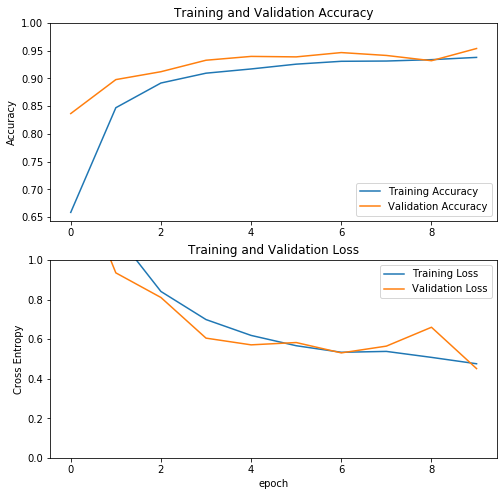

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## 4. FineTuning

In [ ]:
base_model.trainable = True

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 10/20
582/582 [==============================] - 190s 327ms/step - loss: 0.4102 - accuracy: 0.9473 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 11/20
582/582 [==============================] - 178s 305ms/step - loss: 0.3347 - accuracy: 0.9605 - val_loss: 0.1962 - val_accuracy: 0.9763
Epoch 12/20
582/582 [==============================] - 176s 303ms/step - loss: 0.2708 - accuracy: 0.9685 - val_loss: 0.2015 - val_accuracy: 0.9767
Epoch 13/20
582/582 [==============================] - 176s 302ms/step - loss: 0.2291 - accuracy: 0.9715 - val_loss: 0.1999 - val_accuracy: 0.9767
Epoch 14/20
582/582 [==============================] - 176s 302ms/step - loss: 0.2060 - accuracy: 0.9755 - val_loss: 0.1667 - val_accuracy: 0.9763
Epoch 15/20
582/582 [==============================] - 176s 302ms/step - loss: 0.1909 - accuracy: 0.9774 - val_loss: 0.1830 - val_accuracy: 0.9763
Epoch 16/20
582/582 [==============================] - 175s 301ms/step - loss: 0.1219 - accuracy: 0.9838 - val

In [ ]:

acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


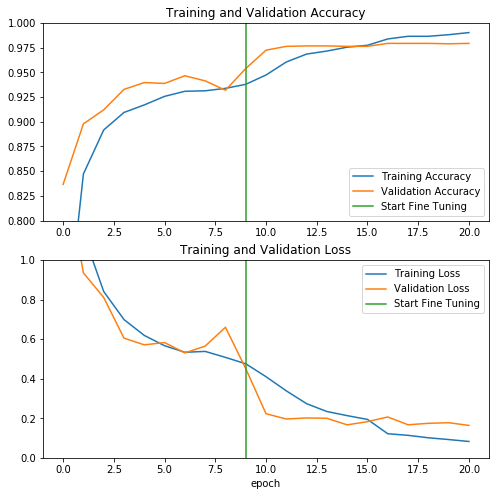

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()